# NARX:

##### NARX Stands for Non-Linear Autoregression with Exogoneous Variables
##### In our case, we model the non-linear relationship with a neural network, following the [MathWorks Article](https://www.mathworks.com/help/deeplearning/ug/design-time-series-narx-feedback-neural-networks.html)

In [1]:
#Import pandas for loading a time series dataframe and matplotlib for some plotting
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Load the Monthly Temperatures Data
#https://finance.yahoo.com/quote/GOOG/history?period1=1640995200&period2=1672531200&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true
df = pd.read_csv("../datasets/GOOG.csv", index_col=0)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-03,144.475494,145.550003,143.502502,145.074493,145.074493,25214000
2022-01-04,145.550507,146.610001,143.816147,144.416504,144.416504,22928000
2022-01-05,144.181000,144.298004,137.523499,137.653503,137.653503,49642000
2022-01-06,137.497498,139.686005,136.763504,137.550995,137.550995,29050000
2022-01-07,137.904999,138.254745,135.789001,137.004501,137.004501,19408000
...,...,...,...,...,...,...
2022-12-23,87.620003,90.099998,87.620003,89.809998,89.809998,17815000
2022-12-27,89.309998,89.500000,87.535004,87.930000,87.930000,15470900
2022-12-28,87.500000,88.519997,86.370003,86.459999,86.459999,17879600


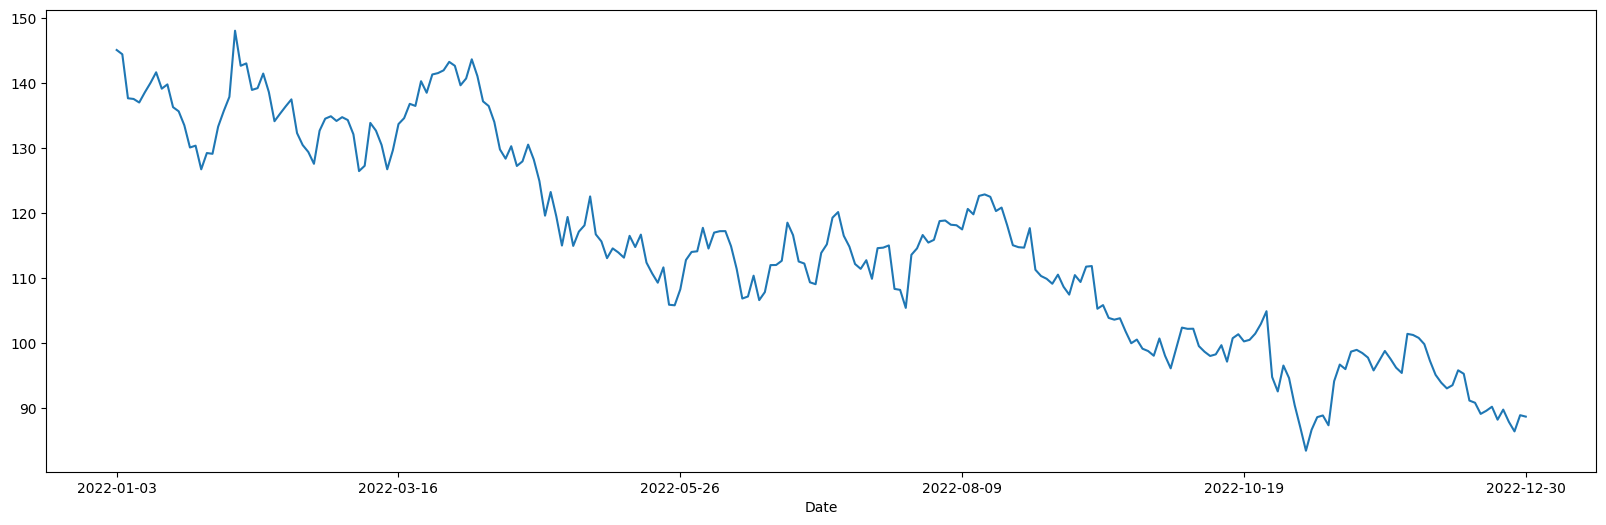

In [3]:
#Plot to visualize the time series data
df["Adj Close"].plot(figsize=(20,6))
plt.show()

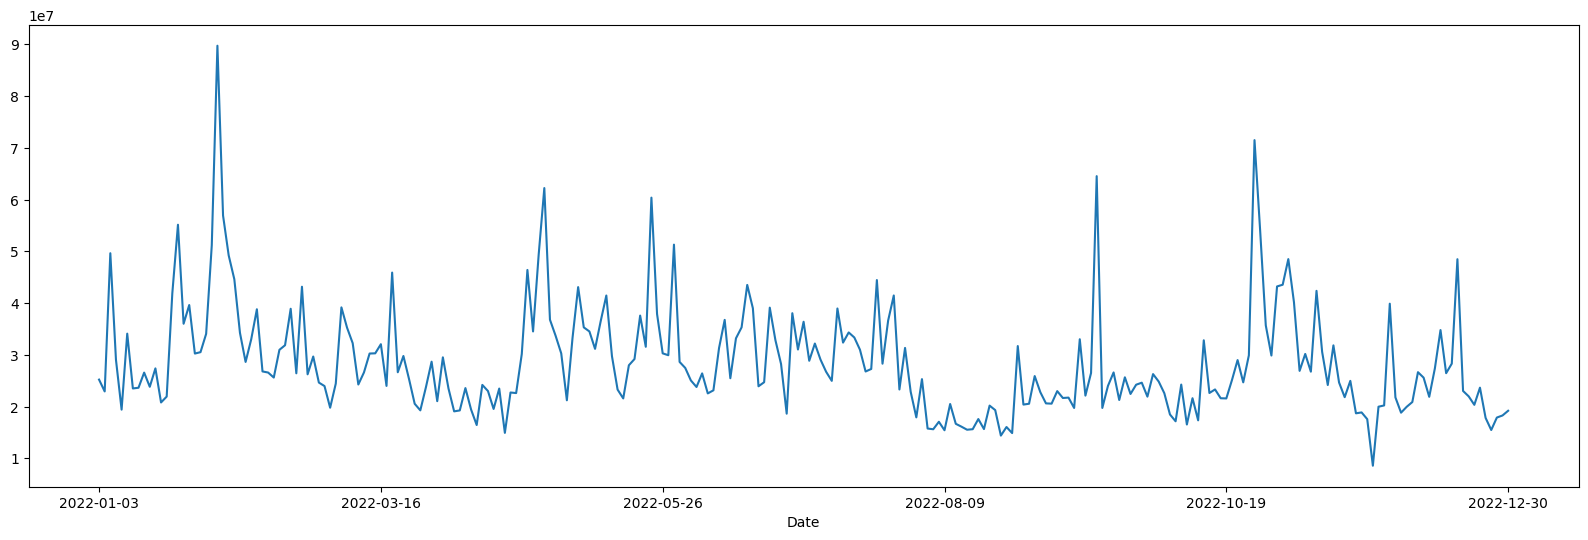

In [4]:
df["Volume"].plot(figsize=(20,6))
plt.show()

### ARIMA models

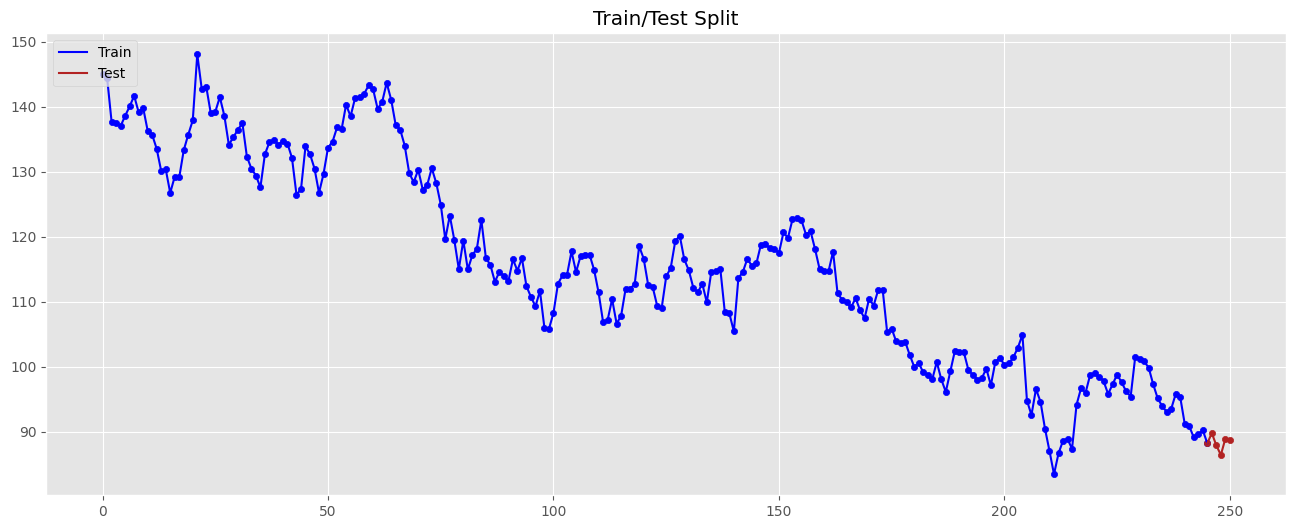

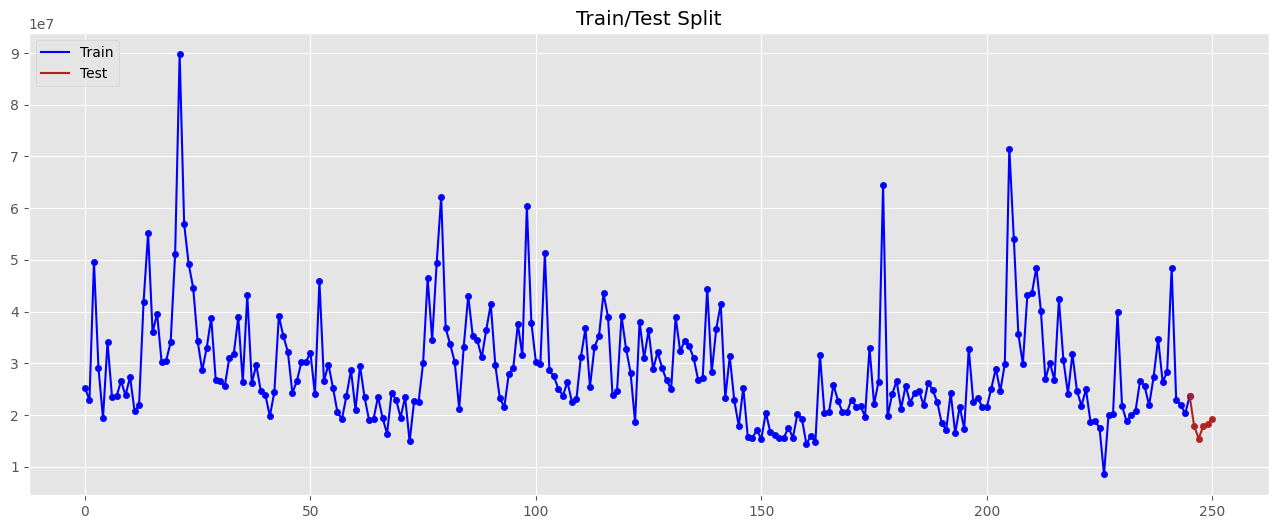

In [5]:
#Before fitting the models, split the data into training and testing;
#We will take the last year of data to test the results of the models
df_train = df[["Adj Close", "Volume"]].iloc[:-5]
df_test = df[["Adj Close", "Volume"]].iloc[-5:]

#Plot the data by calling plot_train_test_split() function from chronokit.utils module
from chronokit.utils import plot_train_test_split
#Take a smaller part of the training data to visualize the test data better
plot_train_test_split(train_data=df_train["Adj Close"], test_data=df_test["Adj Close"], 
                      figsize=(16,6), colors=["blue", "red"], 
                      style="ggplot", title="Train/Test Split")

plot_train_test_split(train_data=df_train["Volume"], test_data=df_test["Volume"], 
                      figsize=(16,6), colors=["blue", "red"], 
                      style="ggplot", title="Train/Test Split")

#### Data Scaling

##### Modeling leads to different results depending on the scale of the data
##### Our data ranges from 100 to 600s; so scaling it may lead to better results
##### We'll use BoxCox transformation; which is a type of power transformation to scale the data
* y_scaled = (y**lambda - 1)/lambda if lambda != 0 else ln(y)

* [wikipedia page on Box-Cox](https://en.wikipedia.org/wiki/Power_transform#Box%E2%80%93Cox_transformation)

In [6]:
from chronokit.preprocessing import MinMaxScaling

#Instantiate the boxcox transformation class
bc_scaler = MinMaxScaling()

#Scale the training data by estimating lambda (scaling parameter)
scaled_train = bc_scaler.transform(df_train)

#Scale the test data by using the lambda value estimated during scaling the training data
#Transformation classes store their scaling parameters after each scaling
#By providing lambda_values = bc_scaler.lambdas; we use the same lambda used during scaling the train data
scaled_test = bc_scaler.transform(df_test, mins=bc_scaler.mins, maxes=bc_scaler.maxes)

In [7]:
y_train, x_train = scaled_train[:, 0], scaled_train[:, 1]
y_test, x_test = scaled_test[:, 0], scaled_test[:, 1]

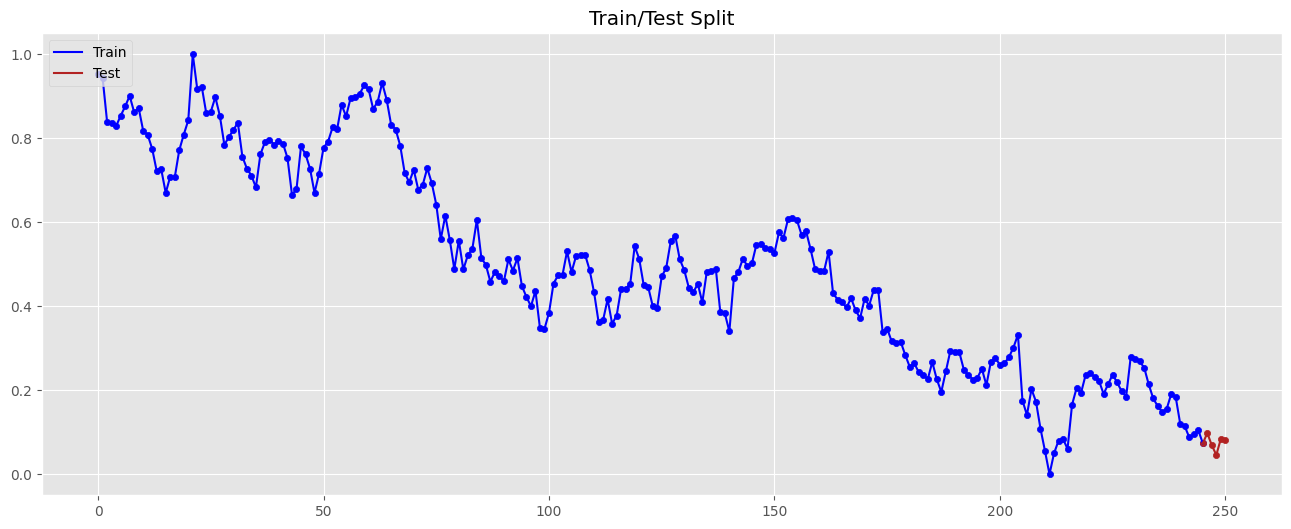

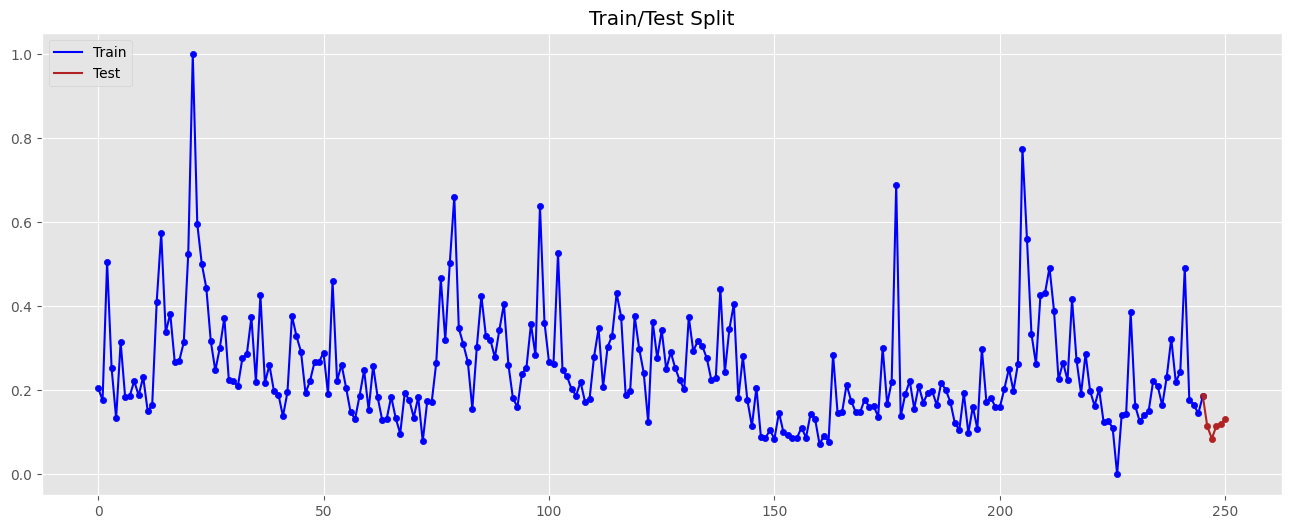

In [8]:
plot_train_test_split(train_data=y_train, test_data=y_test, 
                      figsize=(16,6), colors=["blue", "red"], 
                      style="ggplot", title="Train/Test Split")

plot_train_test_split(train_data=x_train, test_data=x_test, 
                      figsize=(16,6), colors=["blue", "red"], 
                      style="ggplot", title="Train/Test Split")

In [260]:
from chronokit.networks import NARX

narx_model = NARX(data=y_train, exogenous_data=x_train,
                  config={"window": 3,
                          "exog_window": 1,
                          "batch_size": 1,
                          "lr": 2e-3,
                          "hidden_size":1})

In [261]:
#We can see some info about the model by its .info attribute
narx_model.info

{'model': 'NARX',
 'model_config': {'batch_size': 1,
  'hidden_size': 1,
  'device': 'cpu',
  'window': 3,
  'exog_window': 1,
  'optimizer': torch.optim.adamw.AdamW,
  'lr': 0.002,
  'criterion': MSELoss(),
  'batch_norm_momentum': 0.0,
  'dropout': 0.0}}

In [262]:
hist = narx_model.fit(epochs=20, verbose=True)

Epoch [1/20] - Loss: 0.4748
Epoch [2/20] - Loss: 0.3025
Epoch [3/20] - Loss: 0.2045
Epoch [4/20] - Loss: 0.1451
Epoch [5/20] - Loss: 0.1050
Epoch [6/20] - Loss: 0.0763
Epoch [7/20] - Loss: 0.0550
Epoch [8/20] - Loss: 0.0390
Epoch [9/20] - Loss: 0.0273
Epoch [10/20] - Loss: 0.0190
Epoch [11/20] - Loss: 0.0135
Epoch [12/20] - Loss: 0.0100
Epoch [13/20] - Loss: 0.0080
Epoch [14/20] - Loss: 0.0068
Epoch [15/20] - Loss: 0.0061
Epoch [16/20] - Loss: 0.0057
Epoch [17/20] - Loss: 0.0054
Epoch [18/20] - Loss: 0.0052
Epoch [19/20] - Loss: 0.0051
Epoch [20/20] - Loss: 0.0049


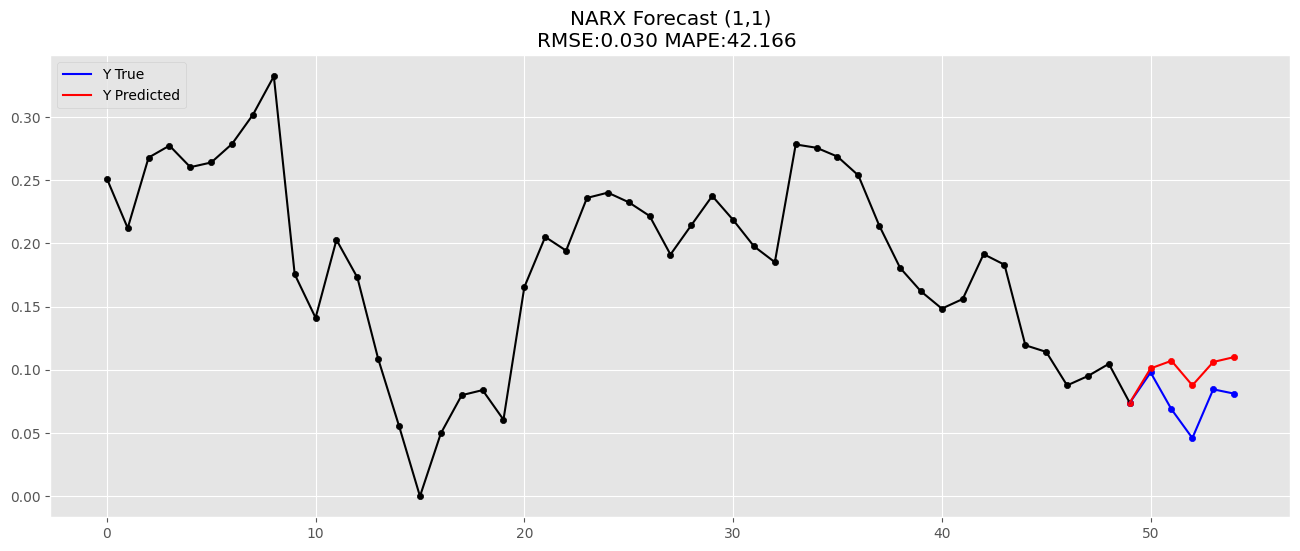

In [264]:
#Visualize the results by calling plot_predictions() from chronokit.utils module
from chronokit.utils import plot_predictions

#For forecasting, call the .predict() method with providing the forecasting horizon (h) as the argument
fc = narx_model.predict(5)

#Visualize the predictions
plot_predictions(y_true=y_test, y_pred=fc,
                 pre_vals=y_train[-50:],
                 colors=["blue", "red"], 
                 title="NARX Forecast (1,1)", 
                 metrics=["rmse", "mape"])

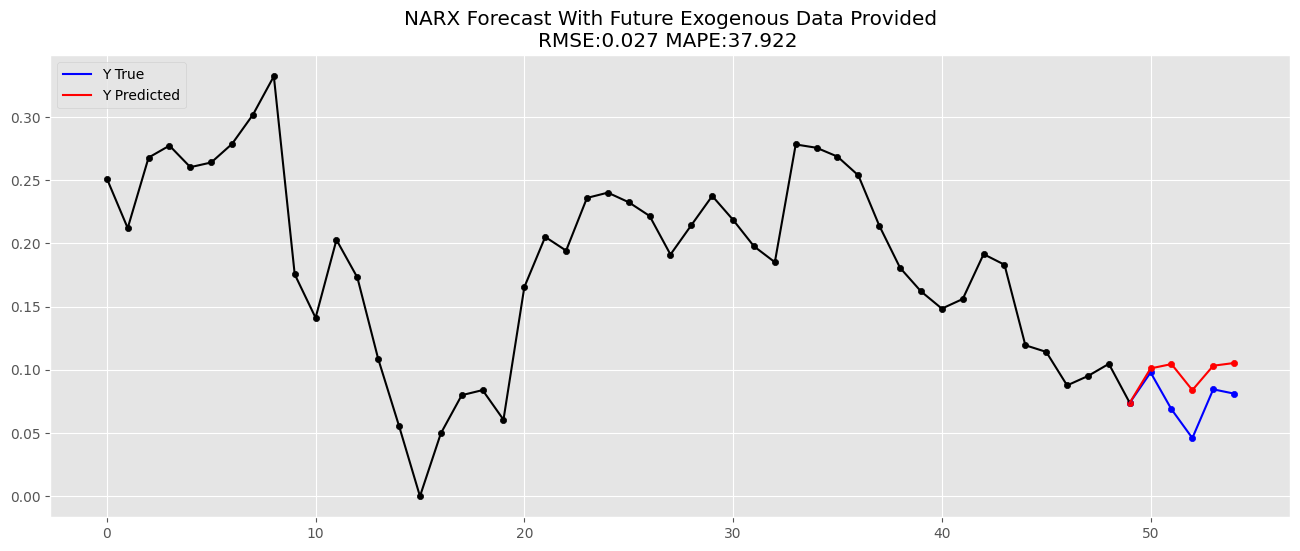

In [265]:
#We can also pass in future exogenous values to see if it improves forecast performance
#In this case, it is not applicable as future values of Volume is not known
#However; it can be applied when the exogenous values are predetermined
#For example if we have used day of month as an exogenous value 
fc = narx_model.predict(5, exogenous_inputs=x_test)

#Visualize the predictions
plot_predictions(y_true=y_test, y_pred=fc,
                 pre_vals=y_train[-50:],
                 colors=["blue", "red"], 
                 title="NARX Forecast With Future Exogenous Data Provided", 
                 metrics=["rmse", "mape"])

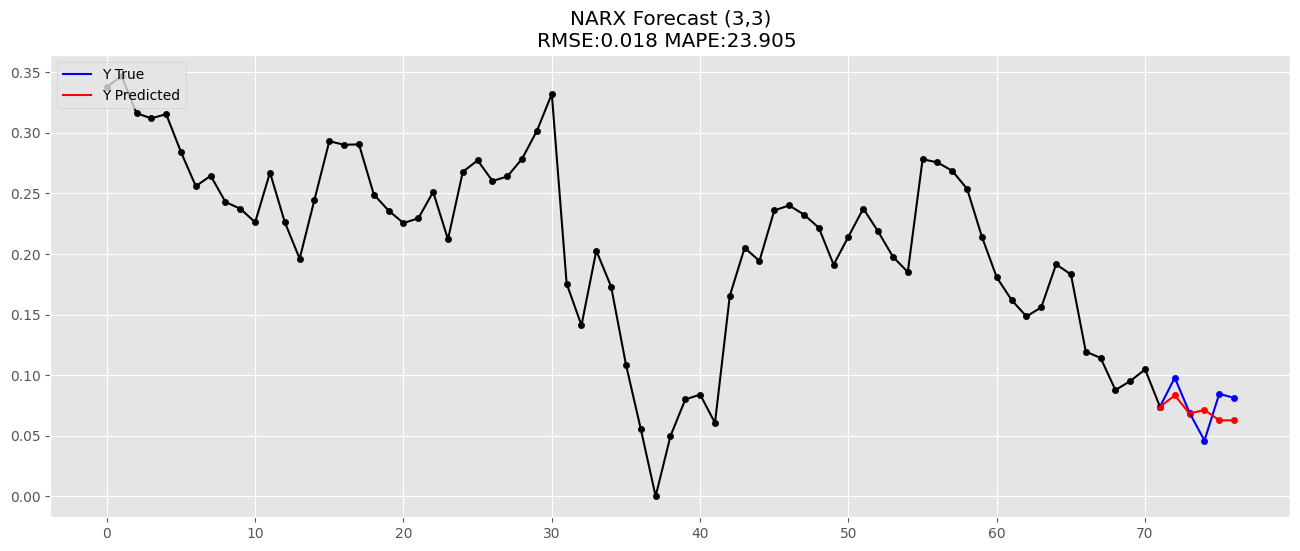

In [266]:
#Let's see if we can achieve better results by changing model configuration
narx_model = NARX(data=y_train, exogenous_data=x_train,
                  config={"window": 3,
                          "exog_window": 3,
                          "batch_size": 8,
                          "lr": 1e-3,
                          "hidden_size":32})
hist = narx_model.fit(epochs=30, verbose=False)
fc = narx_model.predict(5)

#We can see the performance was improved
plot_predictions(y_true=y_test, y_pred=fc,
                 pre_vals=y_train[-72:],
                 colors=["blue", "red"], 
                 title="NARX Forecast (3,3)", 
                 metrics=["rmse", "mape"])

It is important to experiment with different configurations to achieve better results

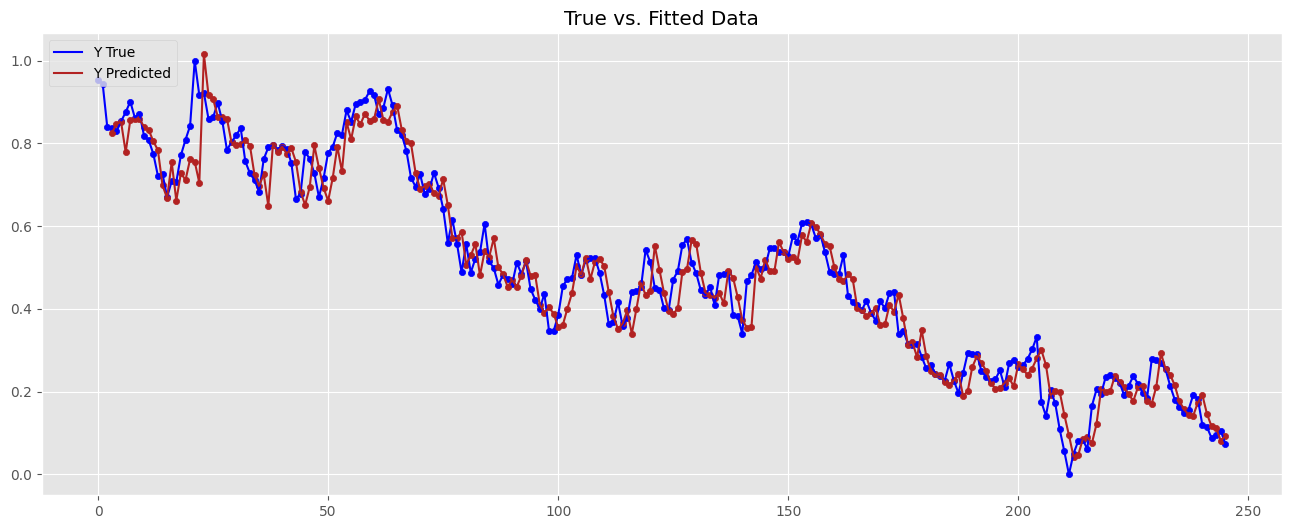

In [267]:
#We can also plot how the model fitted to its given data by calling plot_model_fit()
from chronokit.utils.vis_utils import plot_model_fit
plot_model_fit(narx_model)